## Prototype LBL8R with anndata pytorch loader

### overview.
This notebook protypes a "labelator" (`lbl8r`).  The purpose of a "labelator" is to easily classify _cell types_ for out-of-sample "Test" data. 

Currently we are prototyping with `anndata`.  Crucially it is their anndata loader which is especially useful. AND to state our confirmation bias, it impliments the SCVI models which we like.

We will validate potential models and calibrate them with simple expectations using a typical "Train"/"Validate" and "Test"/"Probe" approach.  


Definitions:
- "Train": data samples on which the model being tested is trained.  The `torch lightning` framework used by `scvi-tools` semi-automatically will "validate" to test out-of-sample prediction fidelity during training.
- "Test": held-out samples to test the fidelity of the model.  
- "Probe": data generated externally,which is _probing_ the fidelity of the model to general scRNAseq data.

-----------------
### Data:
All models will be trained on the n=3000 most highly variable genes from Xylena's scRNAseq data.  

```python 
continuous_covariate_keys = None #noise = ['doublet_score', 'percent.mt', 'percent.rb'] # aka "noise"
layer = "counts"
batch = "sample" #'batch'
categorical_covariate_keys = None #['sample', 'batch'] Currently limited to single categorical...
labels = 'cell_type'
size_factor_key = None # library size 
```
----------------
### Models:
Our general approach will be to "compress" the raw count data, and generate probability of each label category.  We will do this in two ways: 

1) **naive** mode.  Or making no assumptions or attempts to account for confounding variables like "batch", "noise" (e.g. doublets, mt/rb contamination), or "library_size".   

2) **transfer** mode.  i.e. `scarches` or `scvi-tools`.  Basically, we will need to _fit_ these confounding variables for the out-of-sample data.

We'll can do this in either a single **end-to-end** way or in two steps. 

#### 2 step: encode + categorize
In two steps:
1) _encode_: embedding the scRNAseq counts into a latent sub-space
    - VAE (e.g. MMD-VAE, infoVAE etc)

2) _categorize_: predicting creating a probability of a each category 
    - Linear classifier (e.g. multinomial Logistic Regression)
    - NN non-linear classifier 
    - boosted trees (XGboost)


    
We will use a variety of models to "embed" the scRNAseq counts into lower dimension.
- scVI latents

#### end-to-end
We can also try some _end-to-end_ approaches where a single model takes us from raw counts to category probabilities.
- __naive__
    - boosted trees (e.g. xgboost)
    - cVAE
    - trVAE
- __transfer__
    - scANVI


----------------
### training & validation
Models will be trained on the "train" set from xylena's "clean" data.   Validation on a subset of the training data will ensure that overfitting is not a problem.  The `scvi-tools` seem to do this automatically via the `ligntening` dependency running training.

- scVI
    - batch/sample/depth params vs. neutered
- scANVI
    - 


- _naive_ batch correction
- fit a model with a latent "batch" from the 


>scVI: encoder, latent_i, latent_batch_i, latent_library_i, (x_hat = vae(x))

>scANVI: encoder, latent_i, latent_batch_i, latent_library_i, (x_hat = vae(x))


----------------
### inference :: _testing_ :: _probing_
Two types of "inference" modes will be considered.  
1) batch corrected (scVI/scANVI) which requires transfer learning on the probe data
2) naive, which simply processes the examples

------------
### metrics
- pct accuracy  
- ?




### Caveats
There are several gotchas to anticipate:
- features.  Currently we are locked into the 3k genes we are testing with.  Handling subsets and supersets is TBC.
- batch.  In principle each "embedding" or decode part of the model should be able to measure a "batch-correction" parameter explicitly.  in scVI this is explicitly _learned_.  However in _naive_ inference mode it should just be an inferred fudge factor.
- noise.  including or not including `doublet`, `mito`, or `ribo` metrics

## imports / parameters

In [1]:
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    !pip uninstall -y typing_extensions
    !pip install --quiet scvi-colab
    from scvi_colab import install
    install()

In [2]:


from pathlib import Path

import scanpy as sc
import torch

import matplotlib.pyplot as plt
import numpy as np
import anndata as ad

from scvi.model import SCVI

if sys.platform != "darwin":
    torch.set_float32_matmul_precision("medium")  
else:
    print("MPS backend: ",torch.backends.mps.is_available()) #the MacOS is higher than 12.3+
    print("MPS (built): ",torch.backends.mps.is_built()) #MPS is activated

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    
from lbl8r.utils import (
            make_latent_adata,
            add_predictions_to_adata,
            plot_predictions,
            plot_embedding,
            export_ouput_adata,
            make_scvi_normalized_adata,
    )

from lbl8r.lbl8r import scviLBL8R
from lbl8r import get_lbl8r_scvi, add_lbl8r_classifier, prep_lbl8r_adata, query_lbl8r, query_scvi



%load_ext autoreload
%autoreload 2


In [3]:

sc.set_figure_params(figsize=(4, 4))

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

Stubs to find the data

In [4]:
if IN_COLAB:
    root_path = Path("/content/drive/MyDrive/")
    data_path = root_path / "SingleCellModel/data"
else:
    root_path = Path("../")
    if sys.platform == "darwin":
        data_path = root_path / "data/xylena_raw"
    else:
        data_path = root_path / "data/scdata/xylena"
        raw_data_path = root_path / "data/scdata/xylena_raw"

XYLENA_ANNDATA = "brain_atlas_anndata.h5ad"
XYLENA_METADATA = "final_metadata.csv"
XYLENA_ANNDATA2 = "brain_atlas_anndata_updated.h5ad"

XYLENA_TRAIN = XYLENA_ANNDATA.replace(".h5ad", "_train_cnt.h5ad")
XYLENA_TEST = XYLENA_ANNDATA.replace(".h5ad", "_test_cnt.h5ad")

XYLENA_TRAIN_SPARSE = XYLENA_TRAIN.replace(".h5ad", "_sparse.h5ad")
XYLENA_TEST_SPARSE = XYLENA_TEST.replace(".h5ad", "_sparse.h5ad")


In [5]:

# # subsample 40k cells for prototyping
# subsamples = np.random.choice(train_ad.shape[0], 40_000, replace=False)
# train_ad = train_ad[subsamples,:].copy() # no copy... just alias

In [6]:

CELL_TYPE_KEY = "cell_type"
OUT_PATH = data_path / "LBL8R"

## 0. Load training data

In [26]:
filen = data_path / XYLENA_TRAIN
train_ad = ad.read_h5ad(filen)



### scVI model definition

First we need to make the `scVI` model which will constitute our embedding.  This version of the VAE will ignore batch, as outside of the `scarches` _surgery_ framework we don't have a good strategy.  If we are going to use that strategy, we'll use `scANVI` for classificaiton.

Here we define a helper multilayer perceptron class to use it with a VAE below.

In [27]:

SCVI_LATENT_KEY = "X_scVI"
CELL_TYPE_KEY = 'cell_type'


model_path = root_path / "lbl8r_models"
if not model_path.exists():
  model_path.mkdir()


retrain = False




## 1 setup data and load `scVI` VAE

`setup_anndata` and load model.  (Or instantiate and train)


INFO     File ../lbl8r_models/SCVI_nobatch/model.pt already downloaded                                             


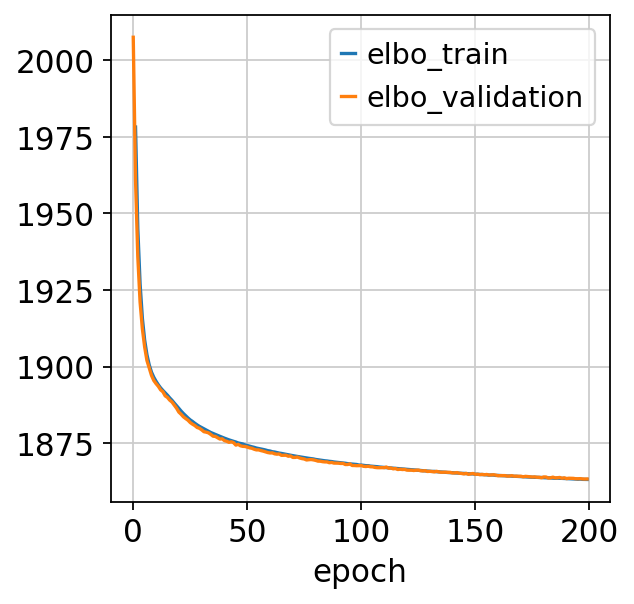

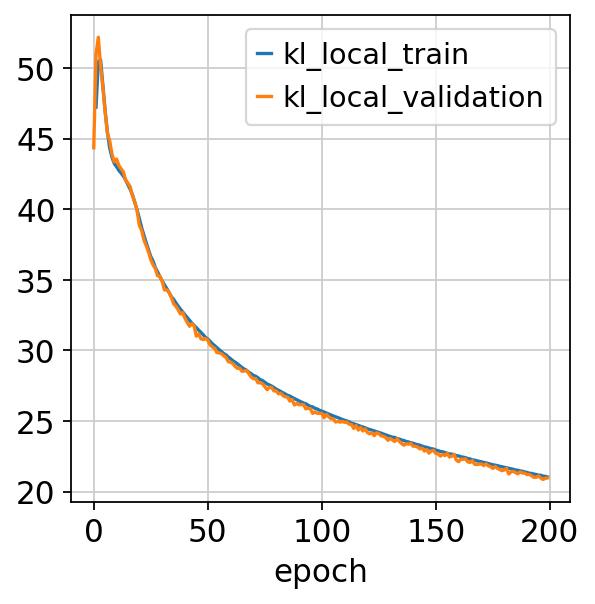

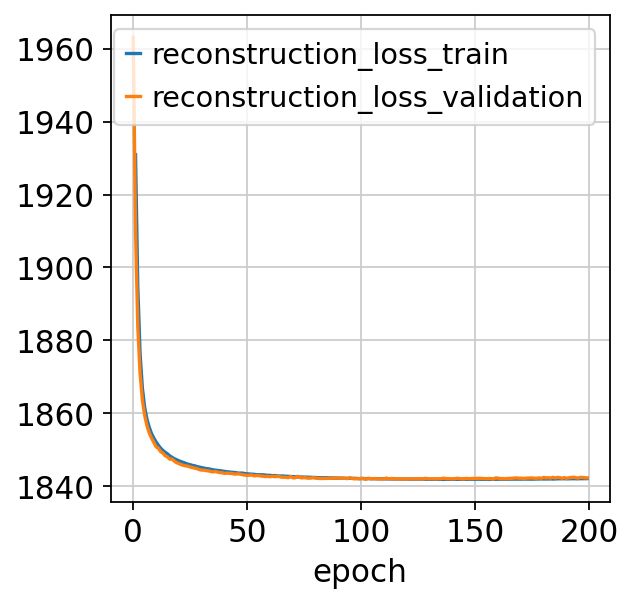

In [28]:

vae, train_ad = get_lbl8r_scvi(
    train_ad,
    labels_key=CELL_TYPE_KEY,
    model_path=model_path,
    retrain=False,
    plot_training=True,
)

In [29]:
train_ad.obs[CELL_TYPE_KEY].value_counts()

Oligo    235183
ExN      110491
InN       53326
Astro     42519
OPC       28883
MG        26529
VC         5154
Name: cell_type, dtype: int64

In [30]:
train_ad

AnnData object with n_obs × n_vars = 502085 × 3000
    obs: 'seurat_clusters', 'cell_type', 'sample', 'doublet_score', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'percent.rb', 'batch', 'sample_other', 'S.Score', 'G2M.Score', 'Phase', 'RNA_snn_res.0.3', 'seurat_clusters_other', 'ExN1', 'InN2', 'MG3', 'Astro4', 'Oligo5', 'OPC6', 'VC7', 'type', 'UMAP_1', 'UMAP_2', 'clean', 'test', 'train', 'tmp', '_scvi_batch', '_scvi_labels'
    var: 'feat'
    uns: 'pca', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'X_pca', 'X_scVI'
    varm: 'PCs'

------------



## 2. Now classify on the latent

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


(502085, 10)
INFO     File ../lbl8r_models/LBL8R_scVI_z/model.pt already downloaded                                             


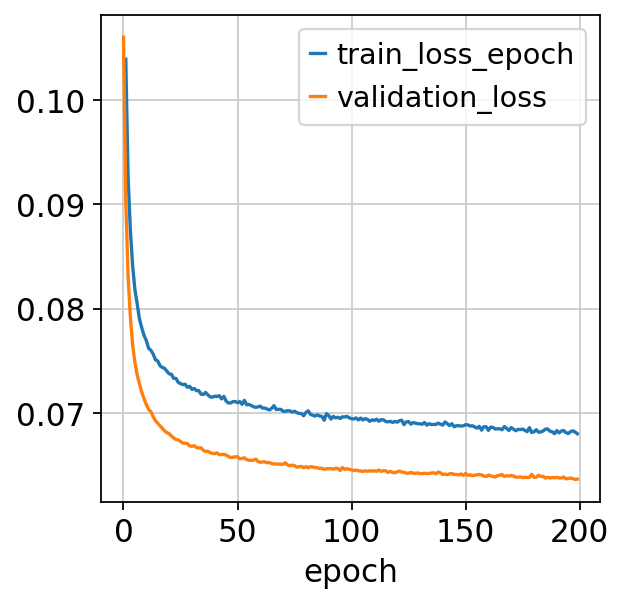

In [31]:

labelator, latent_ad = add_lbl8r_classifier(
    train_ad,
    vae,
    labels_key=CELL_TYPE_KEY,
    model_path=model_path,
    retrain=False,
    plot_training=True,
)

In [32]:
labelator._model_summary_string

'scviLBL8R model'

## 3: visualize prediction fidelity on training set

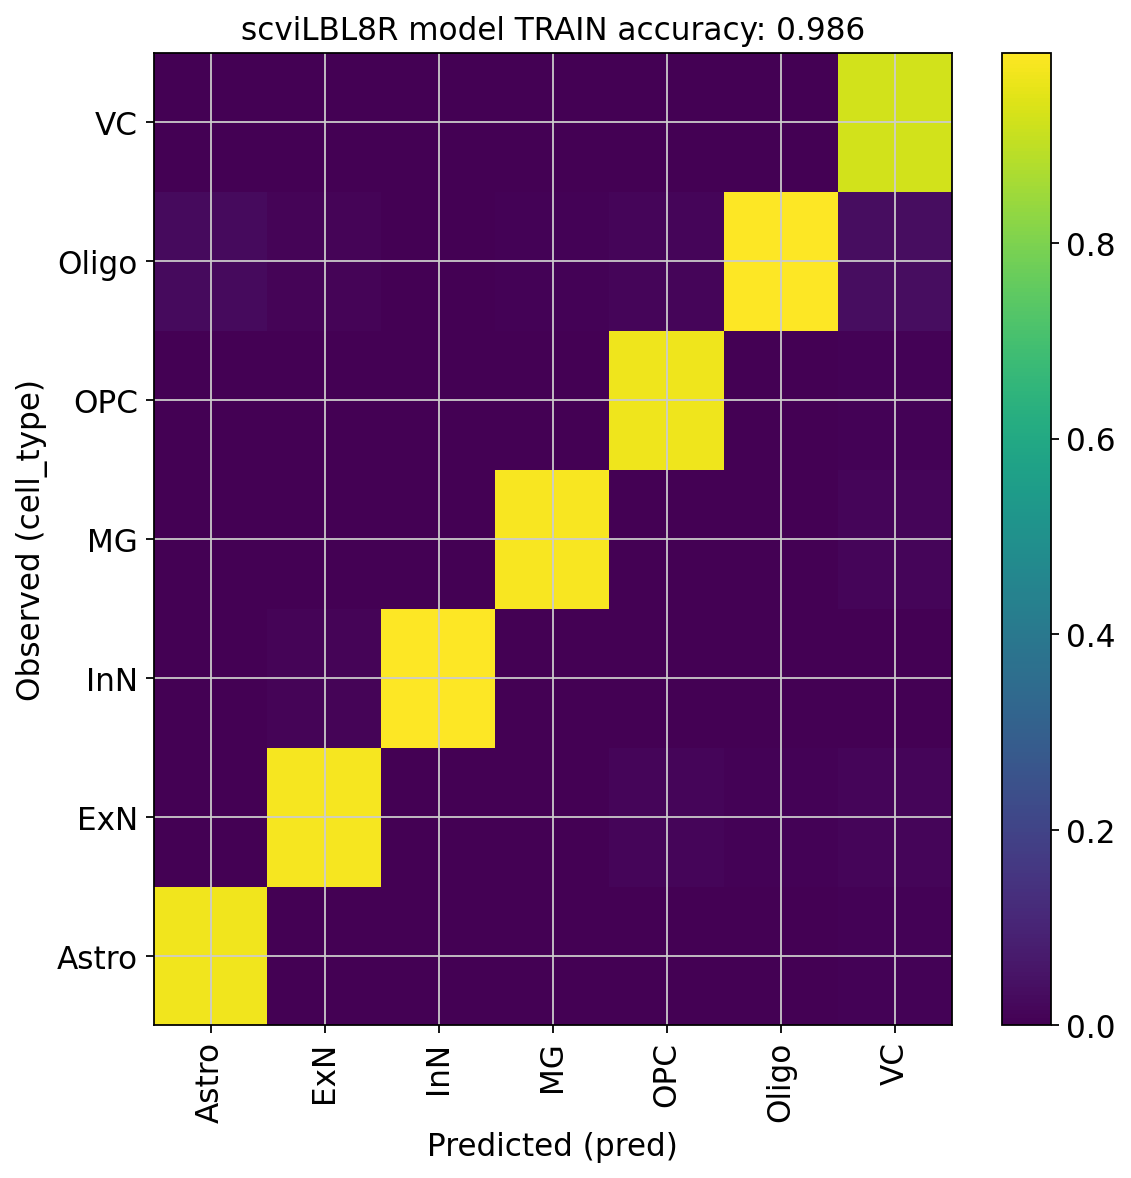

In [33]:
plot_predictions(
    latent_ad,
    pred_key="pred",
    cell_type_key=CELL_TYPE_KEY,
    model_name=labelator._model_summary_string,
    title_str="TRAIN",
)

perfoming mde on cuda


/home/ergonyc/mambaforge/envs/scverse11/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ergonyc/mambaforge/envs/scverse11/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


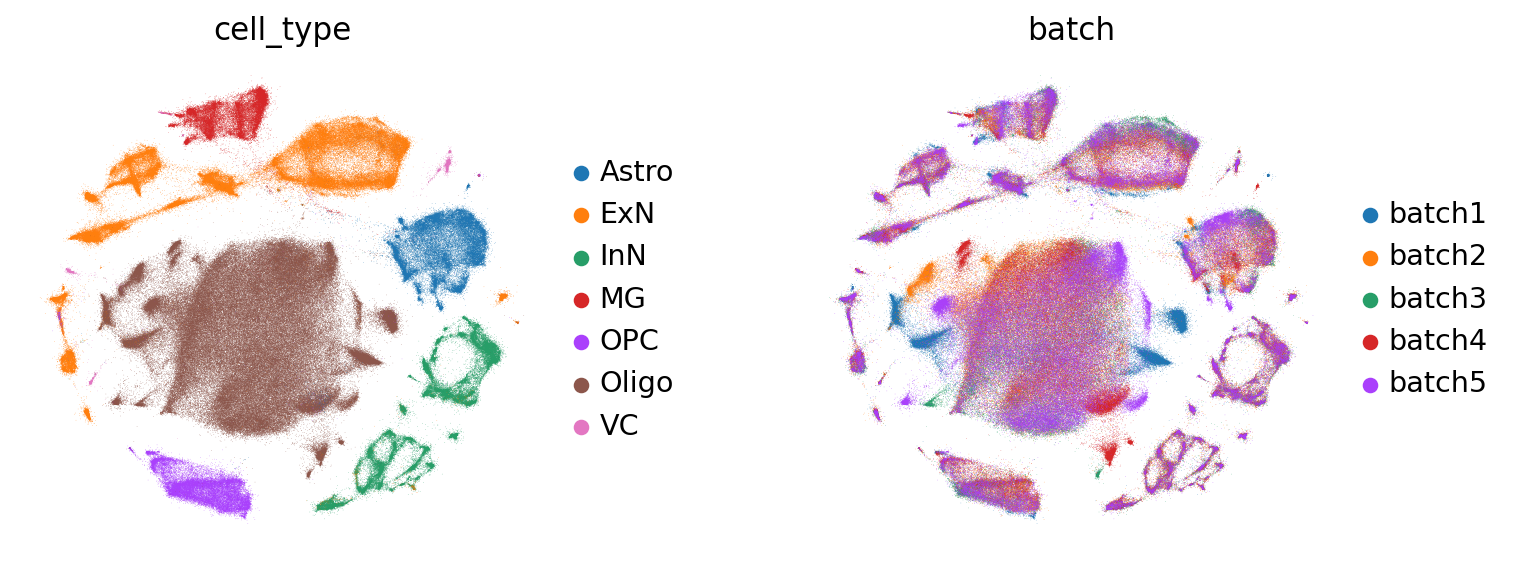

In [34]:
# this should also add the embeddings to the adata
plot_embedding(latent_ad,
               basis="X_scVI_mde",
                color=[CELL_TYPE_KEY, "batch"],
                frameon=False,
                wspace=0.35,
                device="cuda",
                scvi_model = vae)

------------------
## TEST



## 4.  Load data

In [16]:


filen = data_path / XYLENA_TEST
test_ad = ad.read_h5ad(filen)

# subsamples = np.random.choice(test_ad.shape[0], 10_000, replace=False)
# test_ad = test_ad[subsamples,:] # no copy... just alias
test_ad

AnnData object with n_obs × n_vars = 207726 × 3000
    obs: 'seurat_clusters', 'cell_type', 'sample', 'doublet_score', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'percent.rb', 'batch', 'sample_other', 'S.Score', 'G2M.Score', 'Phase', 'RNA_snn_res.0.3', 'seurat_clusters_other', 'ExN1', 'InN2', 'MG3', 'Astro4', 'Oligo5', 'OPC6', 'VC7', 'type', 'UMAP_1', 'UMAP_2', 'clean', 'test', 'train', 'tmp'
    var: 'feat'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

## 5 - prep lbl8r adata and query (run) model

In [17]:
latent_test_ad = prep_lbl8r_adata(test_ad, vae, labels_key=CELL_TYPE_KEY)


latent_test_ad = query_lbl8r(
    latent_test_ad,
    labelator,
    labels_key=CELL_TYPE_KEY,
)

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


(207726, 10)
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
loading adata size=(207726, 10)


## 6.  check the results on out-of-sample data
- plot_predictions
- visualize embeddings


In [54]:
# test_ad.obs["ground_truth"] = test_ad.obs[CELL_TYPE_KEY]
# # pretend like we don't know the cell_type
# test_ad.obs[CELL_TYPE_KEY] = "Unknown"
# # # we can't just project the test data onto the reference model, because the batch variables are unknown
# # scvi_lat = scvi_ref.get_latent_representation(test_ad)

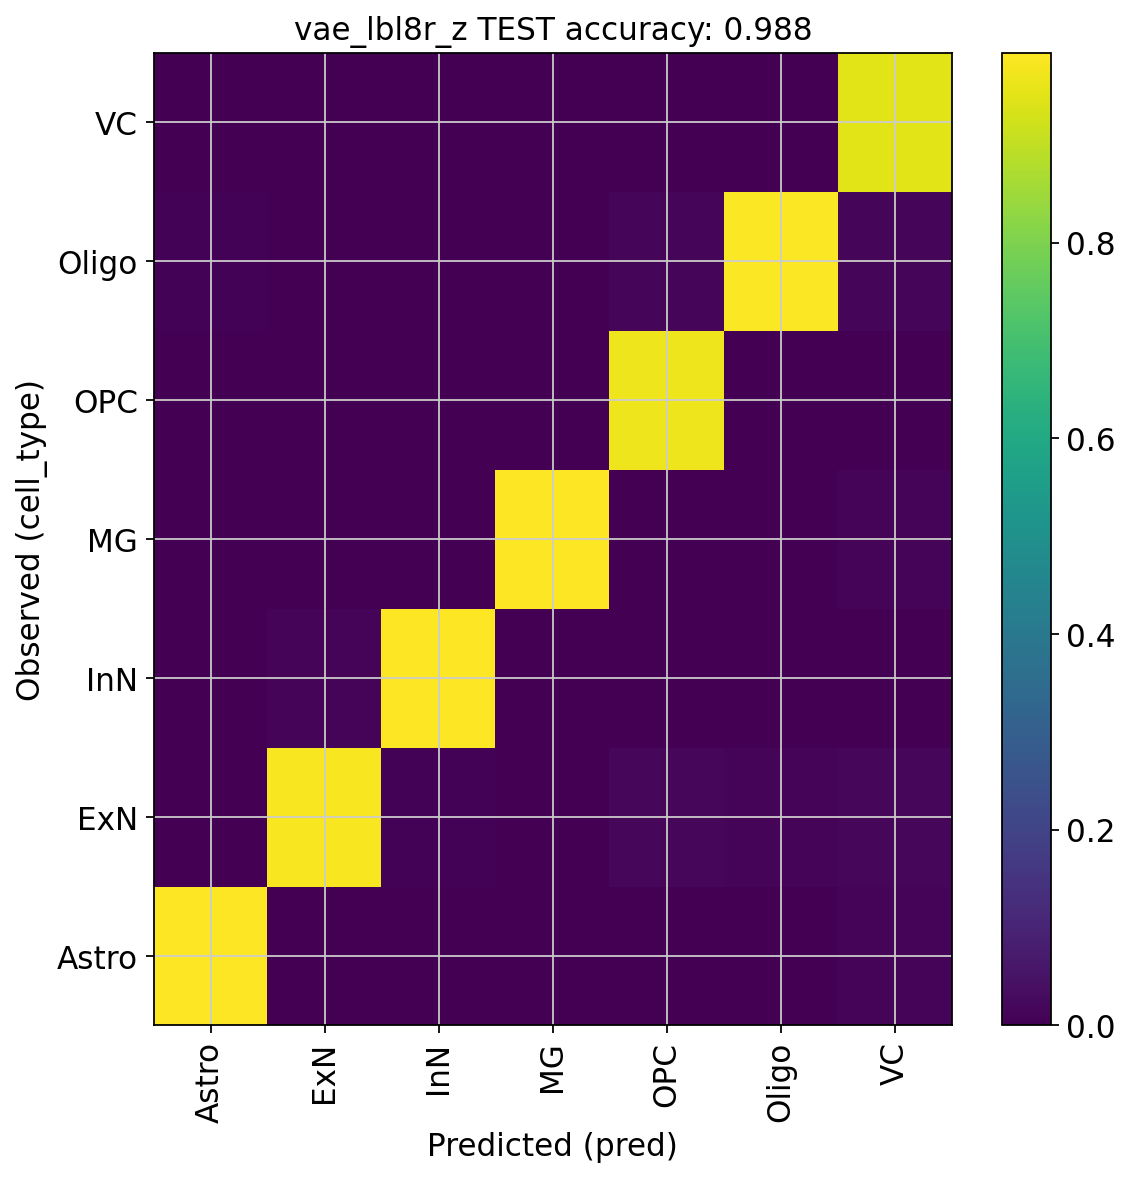

In [18]:
vae._model_summary_string
plot_predictions(latent_test_ad, pred_key="pred", cell_type_key=CELL_TYPE_KEY, model_name="vae_lbl8r_z", title_str="TEST")

perfoming mde on cuda


/home/ergonyc/mambaforge/envs/scverse11/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ergonyc/mambaforge/envs/scverse11/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


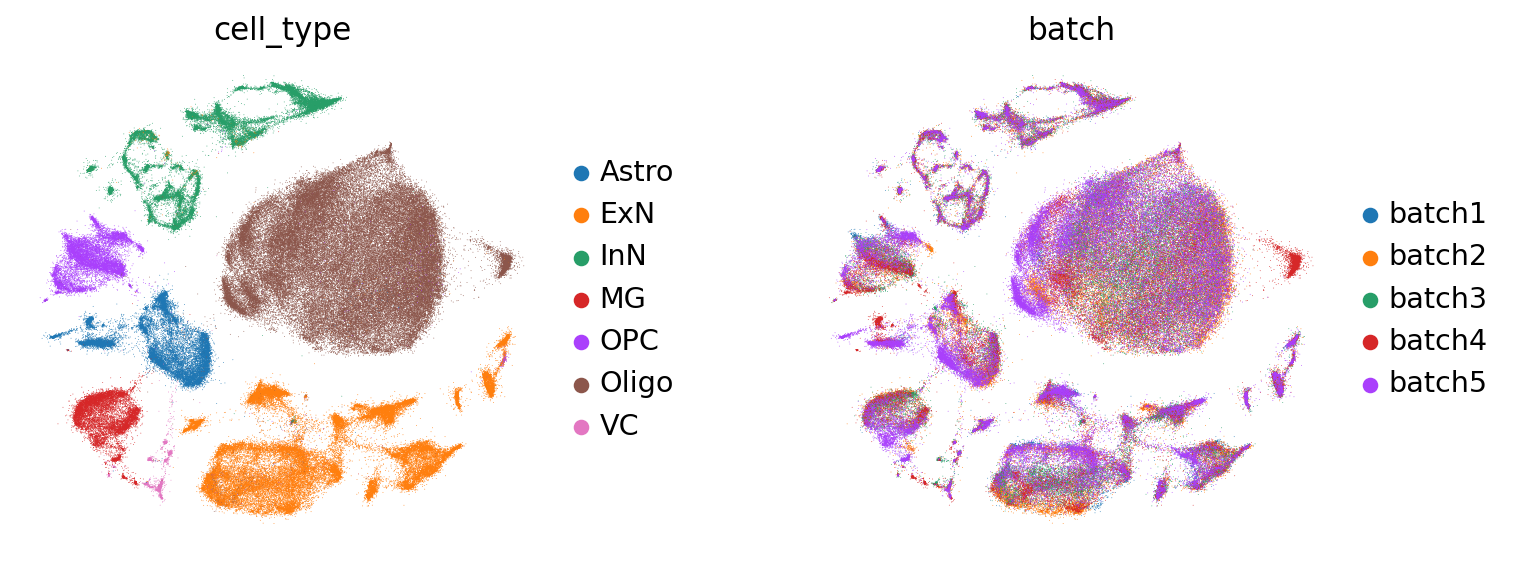

In [19]:
# this should also add the embeddings to the adata
plot_embedding(latent_test_ad,
               basis="X_scVI_mde",
                color=[CELL_TYPE_KEY, "batch"],
                frameon=False,
                wspace=0.35,
                device="cuda",
                scvi_model = vae)

## 7: save versions of test/train with latents and embeddings added

In [20]:
export_ouput_adata(latent_ad, XYLENA_TRAIN.replace("_cnt.h5ad", "_scvi_nb.h5ad"), OUT_PATH)

export_ouput_adata(latent_test_ad, XYLENA_TEST.replace("_cnt.h5ad", "_scvi_nb.h5ad"), OUT_PATH)


wrote: ../data/scdata/xylena/LBL8R/brain_atlas_anndata_train_scvi_nb_out.h5ad
wrote: ../data/scdata/xylena/LBL8R/brain_atlas_anndata_test_scvi_nb_out.h5ad


_______________


--------------
## make scVI normalized adata for further testing... i.e. `pcaLBL8R`

> need to fit a SCVI_query model to get the expressions for the test data (which wasn't nescessary for the rest of the labelators)

- Load the `vae` ("SCVI_nobatch").  
- transform the counts into expression
- make the new AnnData
- save

INFO     Found 100.0% reference vars in query data.                                                                


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 82/150:  55%|█████▍    | 82/150 [08:23<06:57,  6.14s/it, v_num=1, train_loss_step=2.12e+3, train_loss_epoch=1.94e+3]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: 1957.402. Signaling Trainer to stop.


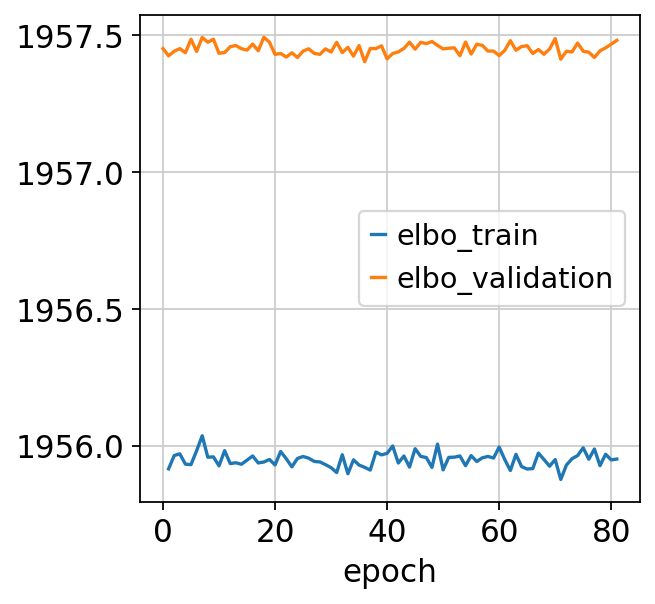

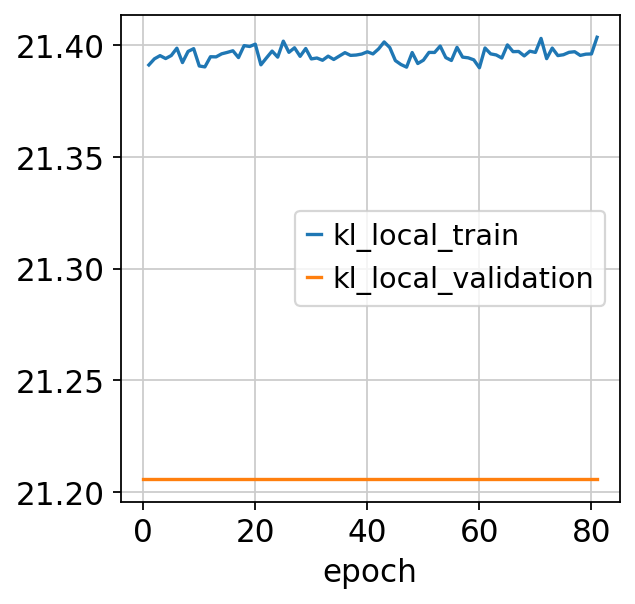

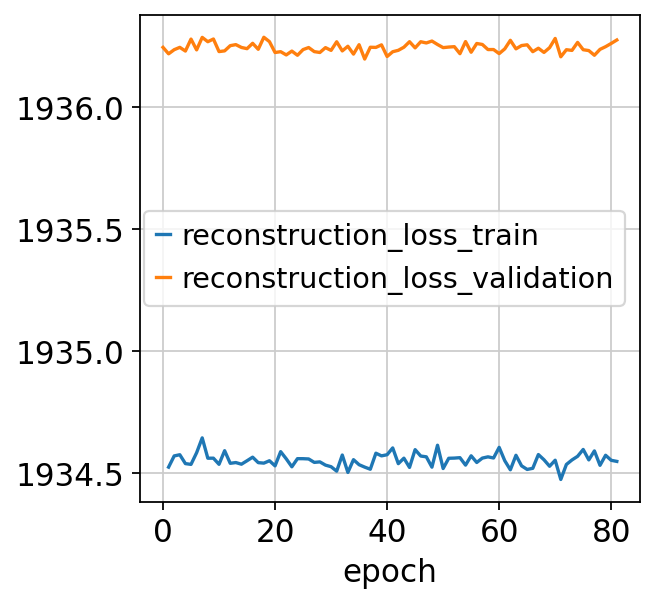

In [23]:

scvi_query, test_ad = query_scvi(
    test_ad,
    vae,
    labels_key=CELL_TYPE_KEY,
    model_path=model_path,
    retrain=False,
    model_name="SCVI_nobatch_query",
    plot_training=True,
)

In [35]:

exp_train_ad = make_scvi_normalized_adata(scvi_query, train_ad)


INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
adding PCs to exp_adata
(502085, 3000)


In [36]:

export_ouput_adata(exp_train_ad, XYLENA_TRAIN.replace("_cnt.h5ad", "_exp_nb.h5ad"), OUT_PATH)


wrote: ../data/scdata/xylena/LBL8R/brain_atlas_anndata_train_exp_nb_out.h5ad


In [37]:

del exp_train_ad, train_ad

exp_test_ad = make_scvi_normalized_adata(scvi_query, test_ad)
export_ouput_adata(exp_test_ad, XYLENA_TEST.replace("_cnt.h5ad", "_exp_nb.h5ad"), OUT_PATH)


adding PCs to exp_adata
(207726, 3000)
wrote: ../data/scdata/xylena/LBL8R/brain_atlas_anndata_test_exp_nb_out.h5ad


In [3]:
import scanpy as sc
import anndata as ad
from lbl8r.utils import transfer_pcs, export_ouput_adata
from pathlib import Path

In [5]:

root_path = Path("../")

data_path = root_path / "data/scdata/xylena"
raw_data_path = root_path / "data/scdata/xylena_raw"

XYLENA_ANNDATA = "brain_atlas_anndata.h5ad"

XYLENA_TRAIN = XYLENA_ANNDATA.replace(".h5ad", "_train_cnt.h5ad")
XYLENA_TEST = XYLENA_ANNDATA.replace(".h5ad", "_test_cnt.h5ad")

OUT_PATH = data_path / "LBL8R"

Reload the files and calculate the PCA of the expression values

In [6]:
filen = OUT_PATH / XYLENA_TRAIN.replace("_cnt.h5ad", "_exp_nb_out.h5ad")
exp_train_ad = ad.read_h5ad(filen)

exp_train_ad

AnnData object with n_obs × n_vars = 502085 × 3000
    obs: 'seurat_clusters', 'cell_type', 'sample', 'doublet_score', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'percent.rb', 'batch', 'sample_other', 'S.Score', 'G2M.Score', 'Phase', 'RNA_snn_res.0.3', 'seurat_clusters_other', 'ExN1', 'InN2', 'MG3', 'Astro4', 'Oligo5', 'OPC6', 'VC7', 'type', 'UMAP_1', 'UMAP_2', 'clean', 'test', 'train', 'tmp', '_scvi_batch', '_scvi_labels'
    var: 'feat'
    obsm: 'X_scVI', '_X_pca'
    varm: '_PCs'

In [7]:
# pcs
sc.pp.pca(exp_train_ad)

In [9]:
exp_train_ad

AnnData object with n_obs × n_vars = 502085 × 3000
    obs: 'seurat_clusters', 'cell_type', 'sample', 'doublet_score', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'percent.rb', 'batch', 'sample_other', 'S.Score', 'G2M.Score', 'Phase', 'RNA_snn_res.0.3', 'seurat_clusters_other', 'ExN1', 'InN2', 'MG3', 'Astro4', 'Oligo5', 'OPC6', 'VC7', 'type', 'UMAP_1', 'UMAP_2', 'clean', 'test', 'train', 'tmp', '_scvi_batch', '_scvi_labels'
    var: 'feat'
    uns: 'pca'
    obsm: 'X_scVI', '_X_pca', 'X_pca'
    varm: '_PCs', 'PCs'

In [10]:
filen = OUT_PATH / XYLENA_TEST.replace("_cnt.h5ad", "_exp_nb_out.h5ad")
exp_test_ad = ad.read_h5ad(filen)
exp_test_ad

AnnData object with n_obs × n_vars = 207726 × 3000
    obs: 'seurat_clusters', 'cell_type', 'sample', 'doublet_score', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'percent.rb', 'batch', 'sample_other', 'S.Score', 'G2M.Score', 'Phase', 'RNA_snn_res.0.3', 'seurat_clusters_other', 'ExN1', 'InN2', 'MG3', 'Astro4', 'Oligo5', 'OPC6', 'VC7', 'type', 'UMAP_1', 'UMAP_2', 'clean', 'test', 'train', 'tmp', '_scvi_batch', '_scvi_labels'
    var: 'feat'
    obsm: 'X_scVI', '_X_pca'
    varm: '_PCs'

In [11]:
exp_test_ad = transfer_pcs(exp_train_ad, exp_test_ad)
exp_test_ad

AnnData object with n_obs × n_vars = 207726 × 3000
    obs: 'seurat_clusters', 'cell_type', 'sample', 'doublet_score', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'percent.rb', 'batch', 'sample_other', 'S.Score', 'G2M.Score', 'Phase', 'RNA_snn_res.0.3', 'seurat_clusters_other', 'ExN1', 'InN2', 'MG3', 'Astro4', 'Oligo5', 'OPC6', 'VC7', 'type', 'UMAP_1', 'UMAP_2', 'clean', 'test', 'train', 'tmp', '_scvi_batch', '_scvi_labels'
    var: 'feat'
    uns: 'pca'
    obsm: 'X_scVI', '_X_pca', 'X_pca'
    varm: '_PCs', 'PCs'

resave the adatas with the pcs

In [12]:
export_ouput_adata(exp_train_ad, XYLENA_TRAIN.replace("_cnt.h5ad", "_exp_nb.h5ad"), OUT_PATH)
export_ouput_adata(exp_test_ad, XYLENA_TEST.replace("_cnt.h5ad", "_exp_nb.h5ad"), OUT_PATH)


wrote: ../data/scdata/xylena/LBL8R/brain_atlas_anndata_train_exp_nb_out.h5ad
wrote: ../data/scdata/xylena/LBL8R/brain_atlas_anndata_test_exp_nb_out.h5ad


In [22]:
exp_test_ad = ad.AnnData(
    X=expression,
    obs=latent_test_ad.obs,
    var=test_ad.var,
    obsm=latent_test_ad.obsm,
    varm=test_ad.varm,
)


exp_test_ad.var_names = test_ad.var_names
exp_test_ad.obs_names = test_ad.obs_names
exp_test_ad.obsm["_X_pca"] = test_ad.obsm["X_pca"]
exp_test_ad.varm["_PCs"] = test_ad.varm["PCs"]

exp_test_ad

AnnData object with n_obs × n_vars = 207726 × 3000
    obs: 'seurat_clusters', 'cell_type', 'sample', 'doublet_score', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'percent.rb', 'batch', 'sample_other', 'S.Score', 'G2M.Score', 'Phase', 'RNA_snn_res.0.3', 'seurat_clusters_other', 'ExN1', 'InN2', 'MG3', 'Astro4', 'Oligo5', 'OPC6', 'VC7', 'type', 'UMAP_1', 'UMAP_2', 'clean', 'test', 'train', 'tmp', '_scvi_batch', '_scvi_labels', 'pred_z'
    var: 'feat'
    obsm: 'X_pca', 'X_scVI', 'X_scVI_mde', '_X_pca'
    varm: 'PCs', '_PCs'

In [24]:
exp_test_ad.write_h5ad(data_path / XYLENA_TEST.replace("_cnt.h5ad", "_exp_nb.h5ad"))
export_ouput_adata(exp_test_ad, XYLENA_TEST.replace("_cnt.h5ad", "_exp_nb.h5ad"), OUT_PATH)


Full latent distribution version of the model

In [ ]:
labels_key = "cell_type"
# sca.models.SCVI.setup_anndata(train_ad,labels_key=labels_key, batch_key=None) #"dummy")
n_labels = len(train_ad.obs[labels_key].cat.categories)


lbl8rscvi_path = model_path / "LBL8Rscvi_qzmv"

if lbl8rscvi_path.exists() and not retrain:
    train_ad_ = make_latent_adata(vae, train_ad, return_dist=True)
    vae_lbl8r_qzmv = scviLBL8R.load(lbl8rscvi_path.as_posix(), train_ad_.copy())

else:
    vae_lbl8r_qzmv = scviLBL8R.from_scvi_model(
        vae, train_ad.copy(), n_labels=n_labels, return_dist=True
    )
    vae_lbl8r_qzmv.train(
        max_epochs=scvi_epochs,
        train_size=0.85,
        batch_size=batch_size,
        early_stopping=True,
    )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/200:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 200/200: 100%|██████████| 200/200 [04:50<00:00,  1.45s/it, v_num=1, train_loss_step=0.119, train_loss_epoch=0.0662] 

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [04:50<00:00,  1.45s/it, v_num=1, train_loss_step=0.119, train_loss_epoch=0.0662]


In [ ]:
vae_lbl8r_qzmv.history.keys()

dict_keys(['train_loss_step', 'validation_loss', 'train_loss_epoch'])

<Axes: xlabel='epoch'>

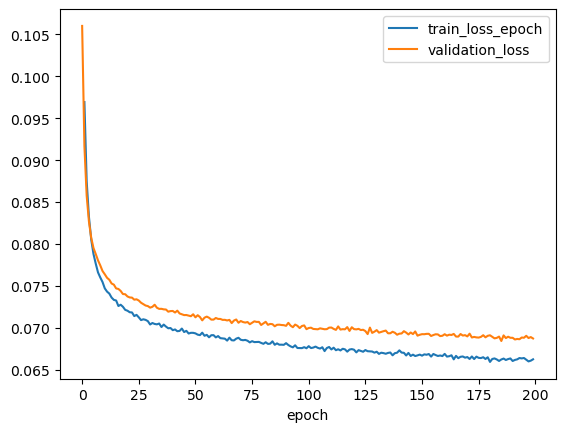

In [ ]:
train_loss = vae_lbl8r_qzmv.history["train_loss_epoch"][1:]
validation_loss = vae_lbl8r_qzmv.history["validation_loss"]

ax = train_loss.plot()
validation_loss.plot(ax=ax)

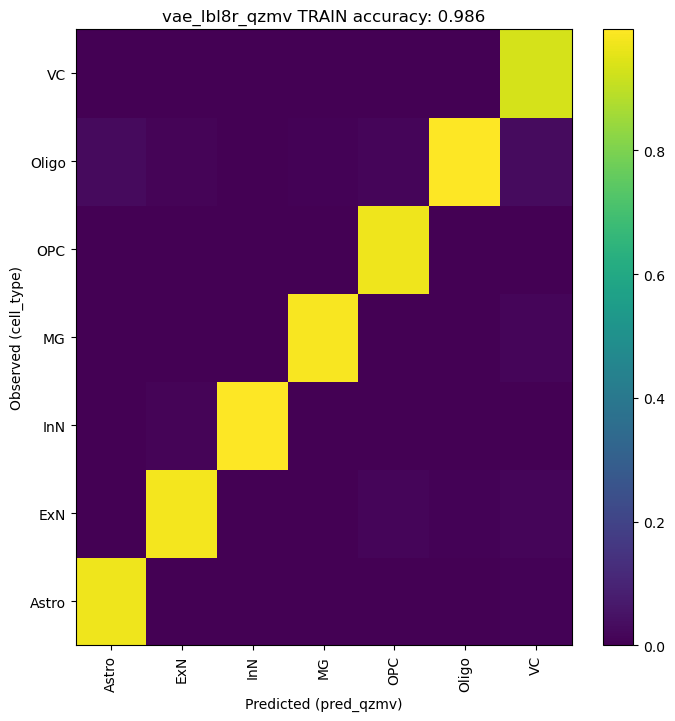

In [ ]:
predictions_qzmv = vae_lbl8r_qzmv.predict( probs=False, soft=True)
train_ad = add_predictions_to_adata(train_ad, predictions_qzmv, insert_key="pred_qzmv", pred_key="label")
plot_predictions(train_ad, pred_key="pred_qzmv", cell_type_key=CELL_TYPE_KEY, model_name="vae_lbl8r_qzmv", title_str="TRAIN")

if retrain or not lbl8rscvi_path.exists():
    lbl8rscvi_path = model_path / "LBL8Rscvi_qzmv"
    vae_lbl8r_qzmv.save(lbl8rscvi_path, overwrite=True)


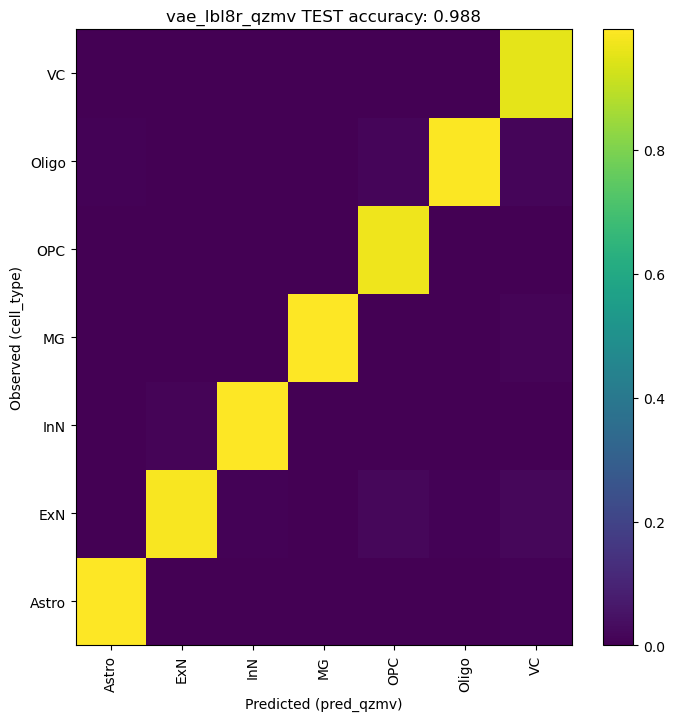

In [ ]:

SCVI.setup_anndata(test_ad.copy(),labels_key=labels_key, batch_key=None) #"dummy")
test_ad_qzmv = test_ad.copy()

scVIqzmd_test_ad = make_latent_adata(vae,test_ad, return_dist=True)
scVIqzmd_test_ad.write_h5ad(data_path / XYLENA_ANNDATA.replace(".h5ad", "_test_scVI_qzmv.h5ad"))
vae_lbl8r_qzmv.setup_anndata(scVIqzmd_test_ad.copy(),labels_key=labels_key) 

predictions_test_qzmv = vae_lbl8r_qzmv.predict( adata=scVIqzmd_test_ad, probs=False, soft=True)




test_ad = add_predictions_to_adata(test_ad, predictions_test_qzmv, insert_key="pred_qzmv", pred_key="label")

plot_predictions(test_ad, pred_key="pred_qzmv", cell_type_key=CELL_TYPE_KEY, model_name="vae_lbl8r_qzmv", title_str="TEST")

In [ ]:
test_ad.write_h5ad(data_path / XYLENA_TEST.replace(".h5ad", "_test_scVI_qzmv_nb.h5ad")) #scVI "no batch" qzmv latents
train_ad.write_h5ad(data_path / XYLENA_TRAIN.replace(".h5ad", "_train_scVI_qzmv_nb.h5ad"))


In [167]:
qzm, qzv = vae.get_latent_representation(give_mean=False, return_dist=True)
vae.adata.obsm["X_latent_qzm"] = qzm
vae.adata.obsm["X_latent_qzv"] = qzv
vae.minify_adata()

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        


<frozen abc>:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.



In [169]:
bdata = vae.adata.copy()
bdata.layers["denoised"] = denoised

In [170]:
pca_denoised = sc.pp.pca(denoised)


/Users/ergonyc/Projects/SingleCell/anndata/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


In [171]:

train_ad.obsm['X_pca2'] = pca_denoised

In [172]:



train_ad.obsm['X_mde2'] = mde(train_ad.obsm['X_pca2'], device="mps")


perfoming mde on mps
Dec 31 04:13:25 PM: edges.device (mps:0) does not match requested device (mps); copying edges to requested device.
Dec 31 04:13:25 PM: distortion_function device (mps:0) does not match requested device (mps); making a copy of distortion_function
Dec 31 04:13:25 PM: The initial iterate's device (mps:0) does not match the requested device (mps). Copying the iterate to mps.


loc("mps_not_equal"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":253:0)): error: 'anec.not_equal_zero' op Invalid configuration for the following reasons: Tensor dimensions N1D1C1H1W698556 are not within supported range, N[1-65536]D[1-16384]C[1-65536]H[1-16384]W[1-16384].
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.not_equal_zero' op Invalid configuration for the following reasons: Tensor dimensions N1D1C1H1W698556 are not within supported range, N[1-65536]D[1-16384]C[1-65536]H[1-16384]W[1-16384].
loc("mps_not"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/L

/Users/ergonyc/miniforge3/envs/scverse11/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/ergonyc/miniforge3/envs/scverse11/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


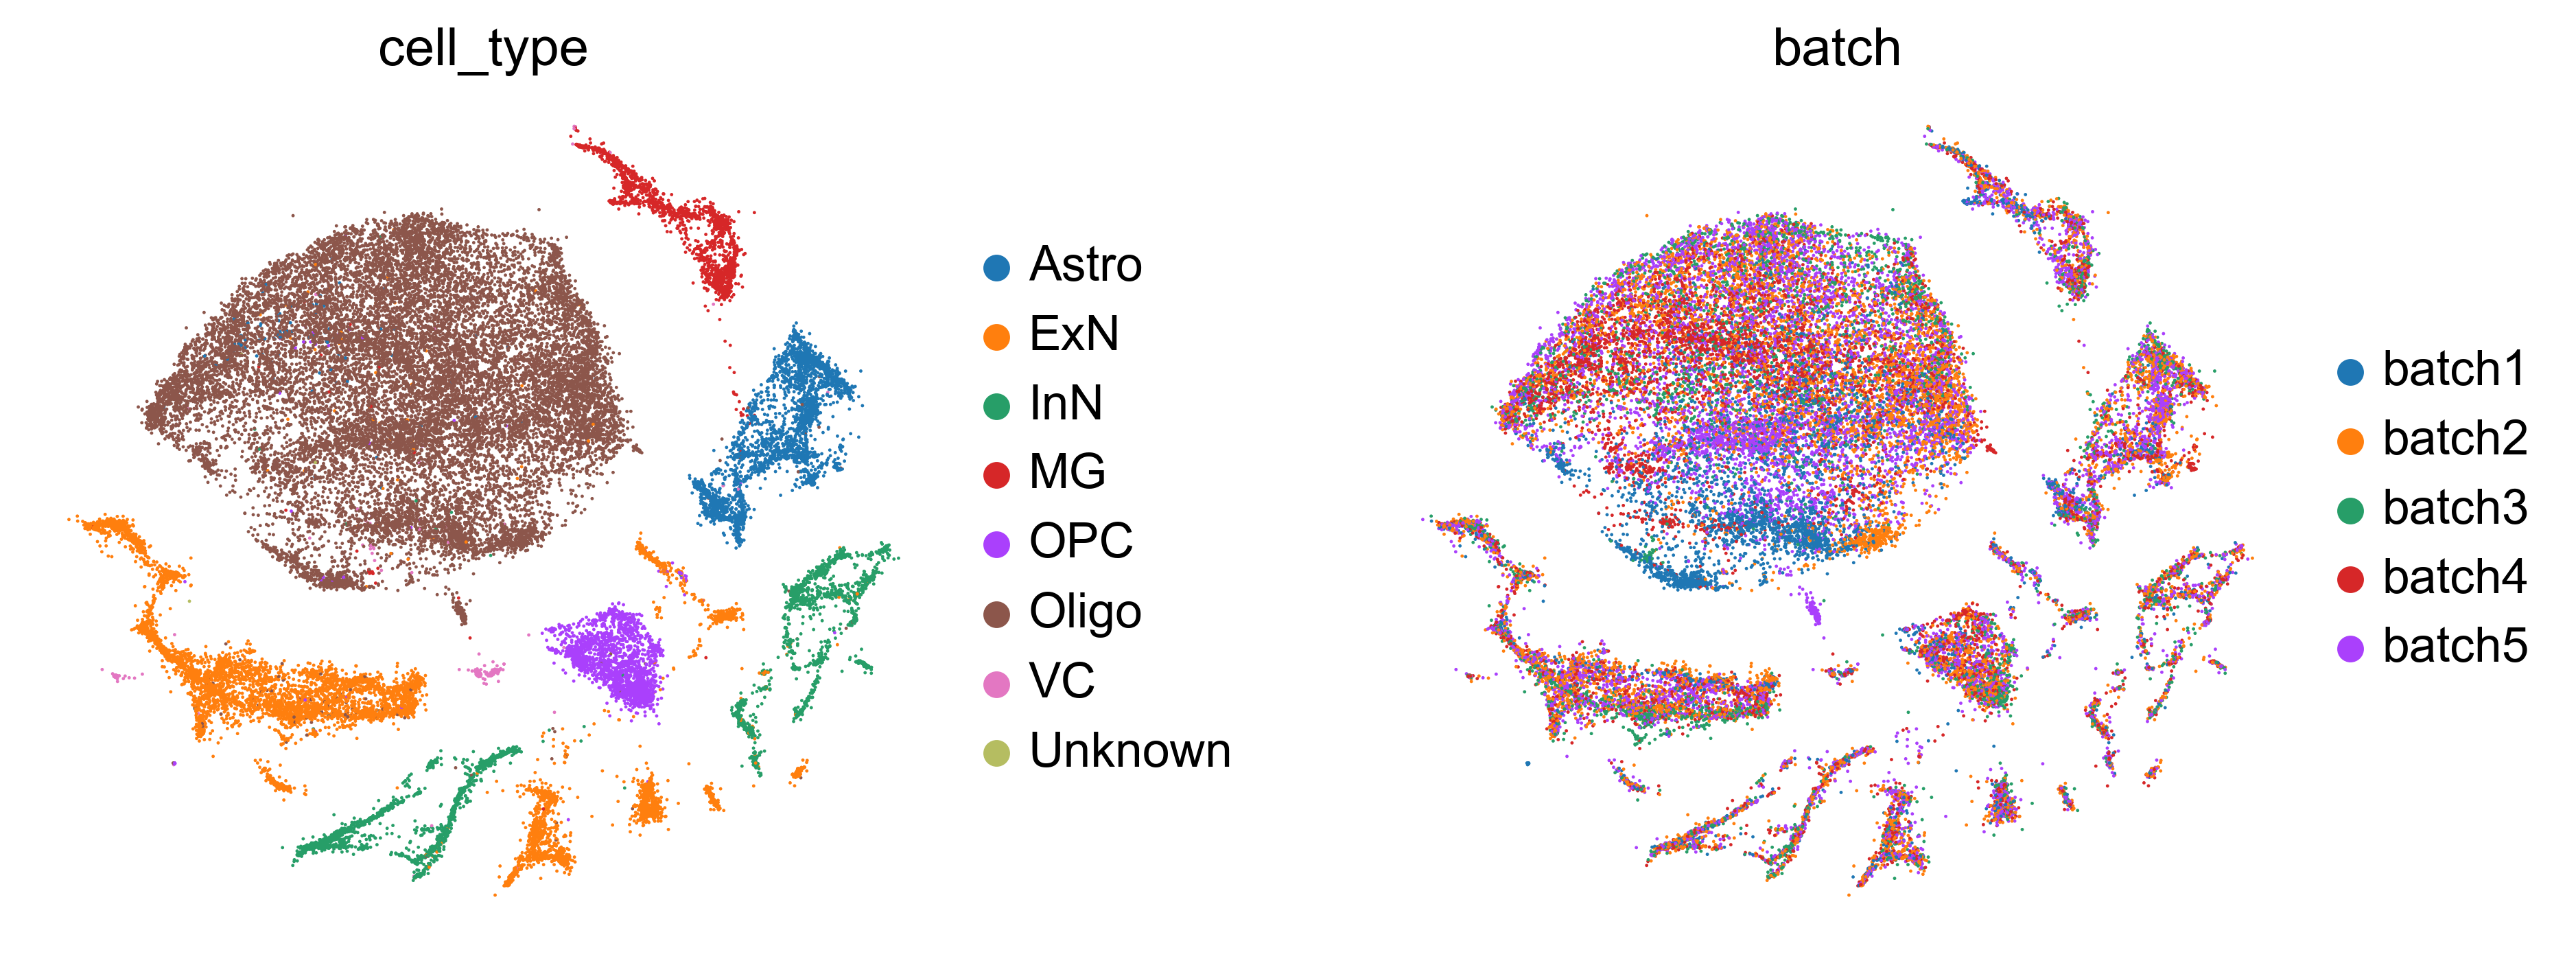

In [173]:

sc.pl.embedding(
    train_ad,
    basis="X_mde2",
    color=[CELL_TYPE_KEY, "batch"],
    frameon=False,
    wspace=0.35,
)

You can also use a custom sampler instead of the default one with automatic bacthing in `AnnLoader`. Just pass your `sampler` and `batch_size`.

In [56]:
# from torch.utils.data import WeightedRandomSampler
adata_latent = sc.AnnData(vae.get_latent())


In [58]:
adata_latent.obs[CELL_TYPE_KEY] = train_ad.obs[cell_type_key].tolist()
adata_latent.obs['batch'] = train_ad.obs[condition_key].tolist()

In [64]:
adata_latent

AnnData object with n_obs × n_vars = 502085 × 10
    obs: 'cell_type', 'batch'

In [31]:
# weights = np.ones(train_ad.n_obs)
# weights[train_ad.obs['cell_type'] == 'Pancreas Stellate'] = 2.
# sampler = WeightedRandomSampler(weights, train_ad.n_obs)

In [32]:
# dataloader = AnnLoader(train_ad, batch_size=128, sampler=sampler, convert=encoders, use_cuda=use_cuda)

We don't use the custom sampler for training the model, so return to the default sampler here.

## Initialize and train the model

Here is the code for our training phase. The AnnLoader object is passed as a dataloader, it iterates through `dataloader.dataset` (as in a standard PyTorch dataloader).

Note that now you can simply take a batch from the dataloader, select a required attribute, do something with it if needed and pass to your loss function. Everything is already converted by the pre-defined converters. You don't need to copy your AnnData object, you don't need a custom dataloader for a dictionary of required keys, all observation keys are already in the bacthes.

## Check the results

In [91]:
full_data = dataloader.dataset[:] # No copies yet, nothing is copied until you access specific attributes (.X, .obsm etc.).

In [92]:
means = cvae.encoder(full_data.X, full_data.obs['sample'])[:, :10] # get mean values of the latent variables

In [93]:
train_ad.obsm['X_cvae'] = means.data.cpu().numpy()

In [94]:
# sc.pp.neighbors(train_ad, use_rep='X_cvae')
# sc.tl.umap(train_ad)

train_ad.obsm['X_mde2'] = scvi.model.utils.mde(train_ad.obsm['X_cvae'])


The results of the study integration using our VAE model.

/Users/ergonyc/miniforge3/envs/scverse11/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/ergonyc/miniforge3/envs/scverse11/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


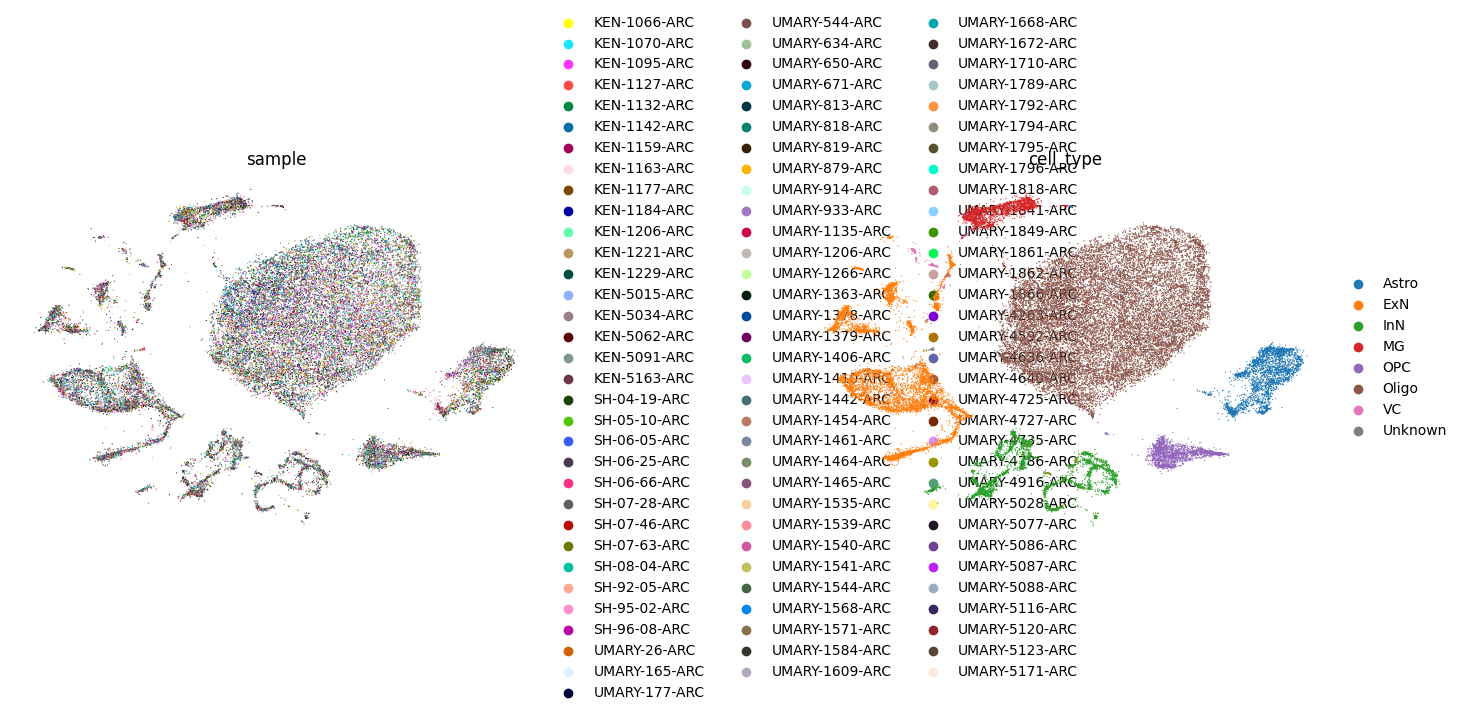

In [95]:
# sc.pl.umap(adata, color=['study', 'cell_type'], wspace=0.35)
# # sc.pl.umap(adata, color=['study', 'cell_type'], wspace=0.35)

sc.pl.embedding(
    train_ad,
    basis="X_mde2",
    color=["sample", "cell_type"],
    frameon=False,
    wspace=0.35,
)


In [117]:
preds = cvae.classifier(means).argmax(dim=-1)
labs = torch.tensor(encoder_celltype.transform(train_ad.obs['cell_type']))
accuracy = (preds==labs).sum().item()/train_ad.n_obs

In [164]:
encoder_celltype.inverse_transform(preds)

array(['VC', 'Oligo', 'ExN', ..., 'MG', 'Oligo', 'Oligo'], dtype=object)

In [99]:
train_ad.n_obs

tensor([[ 2.9354,  1.8235, -0.1486,  ...,  0.0210, -0.0204, -0.0467],
        [-0.2977,  0.7406,  0.3860,  ..., -0.0677,  0.0308, -0.0242],
        [-0.5130,  2.4466,  0.7728,  ...,  0.0406, -0.0267, -0.0259],
        ...,
        [ 1.0070,  1.5476,  1.7903,  ..., -0.0081,  0.0225, -0.0481],
        [-0.5239, -0.5073,  0.7861,  ..., -0.0812,  0.0437,  0.0175],
        [-1.6937, -0.1083,  1.2423,  ..., -0.0870,  0.0597,  0.0088]],
       grad_fn=<SliceBackward0>)

In [186]:
import torch.nn.functional as F
from torch.distributions import Categorical

# Example logits from a neural network output
logits = cvae.classifier(means)

# Applying softmax to convert logits to probabilities
probabilities = F.softmax(logits, dim=1)

# Create a Categorical distribution
distribution = Categorical(probs=probabilities)

# Calculate entropy
entropy = distribution.entropy()

n_classes = probabilities.shape[1]

In [187]:
probabilities[1,:].sum()

tensor(1., grad_fn=<SumBackward0>)

In [188]:

logs = logits.detach().numpy()
probs = probabilities.detach().numpy()
ents = entropy.detach().numpy()
logents = entropy.log().detach().numpy()
maxprob = probs.max(axis=1)

# print("Logits: ", logs)
# print("Probabilities: ", probs)

maxprobs = probs.max(axis=1)


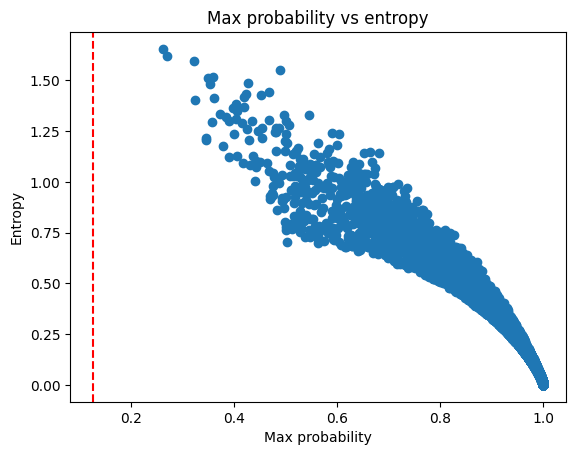

In [190]:
# print("Entropy:", entropy)

# plt.scatter(means[:, 0], means[:, 1], c=entropy)

ax = plt.scatter(maxprobs,ents)
plt.xlabel("Max probability")
plt.ylabel("Entropy")
plt.title("Max probability vs entropy")
plt.axvline(x=1/n_cats, color='r', linestyle='--')


In [191]:
cvae.classifier(means).argmax(dim=-1)

tensor([7, 5, 1,  ..., 3, 5, 5])

In [194]:
train_ad.obs['margin'] = margin.detach().numpy()
train_ad.obs['entropy'] = entropy.detach().numpy()
train_ad.obs['maxprob'] = maxprob
train_ad.obs['pred'] = encoder_celltype.inverse_transform(preds)

/Users/ergonyc/miniforge3/envs/scverse11/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


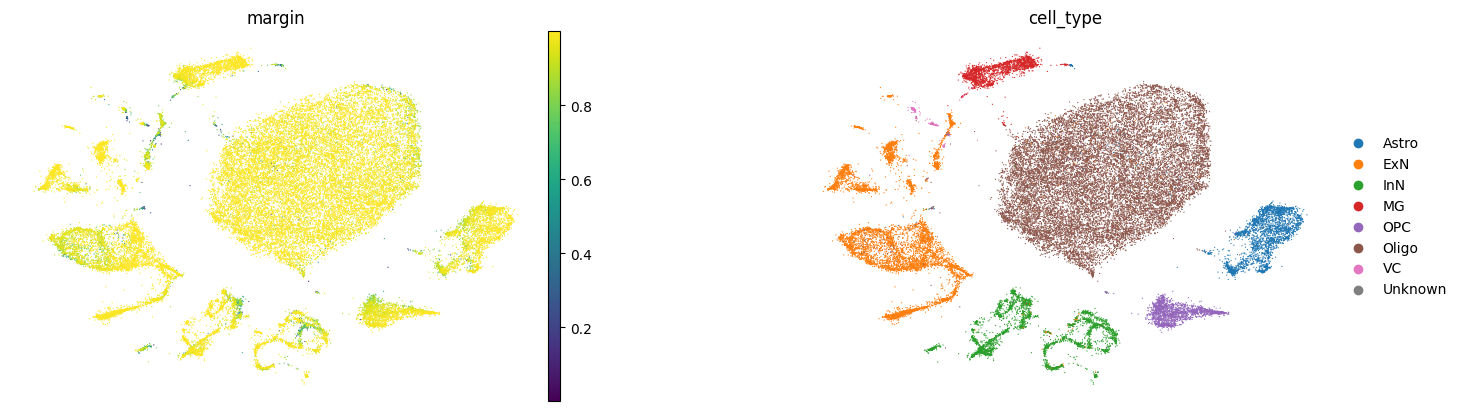

In [195]:
sc.pl.embedding(
    train_ad,
    basis="X_mde2",
    color=["margin", "cell_type"],
    frameon=False,
    wspace=0.35,
)


/Users/ergonyc/miniforge3/envs/scverse11/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


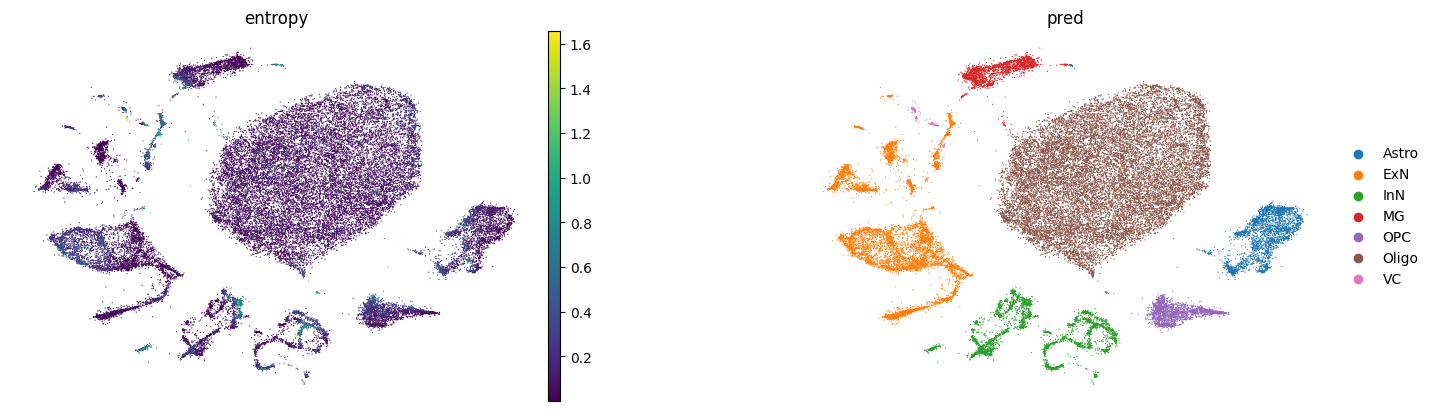

In [196]:
sc.pl.embedding(
    train_ad,
    basis="X_mde2",
    color=["entropy", "pred"],
    frameon=False,
    wspace=0.35,
)


In [198]:
train_ad.obs[train_ad.obs['cell_type']=='Unknown']

seurat_clusters cell_type         sample  \
cells                                                              
CACATAATCAAACCGT-1_138                1   Unknown  UMARY-933-ARC   

                        doublet_score  nCount_RNA  nFeature_RNA  percent.mt  \
cells                                                                         
CACATAATCAAACCGT-1_138       0.089965       11383          4936    0.131775   

                        percent.rb   batch   S.Score  ...    UMAP_2 clean  \
cells                                                 ...                   
CACATAATCAAACCGT-1_138    1.511025  batch5 -0.070626  ... -9.666387  True   

                         test  train                  tmp  size_factors  \
cells                                                                     
CACATAATCAAACCGT-1_138  False   True  nanOligodendrocytes        4374.0   

                          margin   entropy  maxprob  pred  
cells                                                      
CACATAATCAAACCGT-1_138  0.236207  1.085259  0.54742   ExN  

[1 rows x 32 columns]

In [176]:
train_ad.obs['pred']

KeyError: 'pred'

TypeError: Categoricals can only be compared if 'categories' are the same.

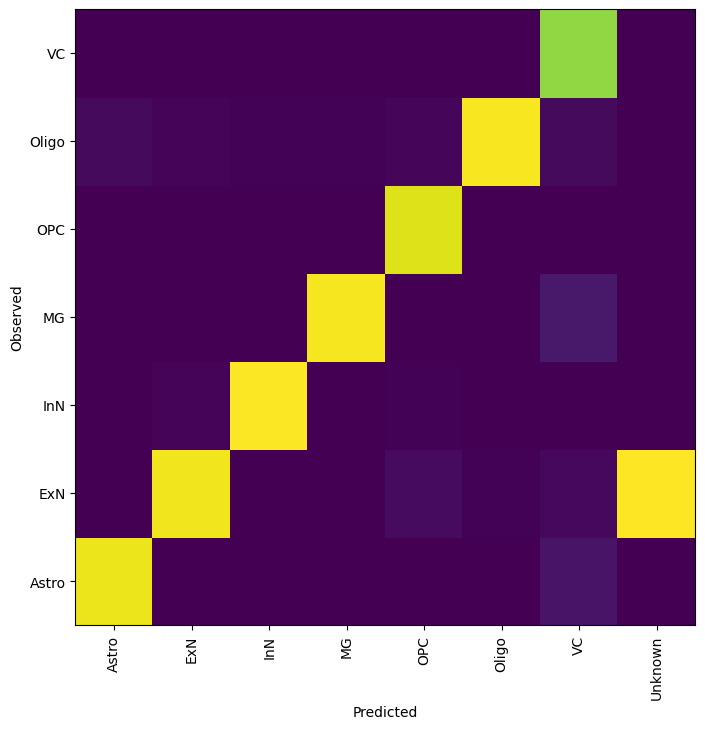

In [231]:
df = train_ad.obs.groupby(["pred", "cell_type"]).size().unstack(fill_value=0)
norm_df = df / df.sum(axis=0)

plt.figure(figsize=(8, 8))
_ = plt.pcolor(norm_df)
_ = plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns, rotation=90)
_ = plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.title(f"scanvi accuracy: {np.mean(train_ad.obs.pred == train_ad.obs.cell_type):.3f}")

## to latent model

In [ ]:
from scvi.nn import DecoderSCVI, Encoder, LinearDecoderSCVI, one_hot


class CVAElat(nn.Module):
    # The code is based on the scarches trVAE model
    # https://github.com/theislab/scarches/blob/v0.3.5/scarches/models/trvae/trvae.py
    # and on the pyro.ai Variational Autoencoders tutorial
    # http://pyro.ai/examples/vae.html
    def __init__(self, input_dim, n_conds, n_classes, hidden_dims, latent_dim):
        super().__init__()
        
        self.encoder = MLP(input_dim+n_conds, hidden_dims, 2*latent_dim) # output - mean and logvar of z
        
        self.decoder = MLP(latent_dim+n_conds, hidden_dims[::-1], input_dim)
        self.theta = nn.Linear(n_conds, input_dim, bias=False)
        
        self.classifier = nn.Linear(latent_dim, n_classes)
        
        self.latent_dim = latent_dim
    
    def model(self, x, batches, classes, size_factors):
        pyro.module("cvae", self)
        
        batch_size = x.shape[0]
        
        with pyro.plate("data", batch_size):
            z_loc = x.new_zeros((batch_size, self.latent_dim))
            z_scale = x.new_ones((batch_size, self.latent_dim))
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
            
            classes_probs = self.classifier(z).softmax(dim=-1)
            pyro.sample("class", dist.Categorical(probs=classes_probs), obs=classes)
            
            dec_mu = self.decoder(z, batches).softmax(dim=-1) * size_factors[:, None]
            dec_theta = torch.exp(self.theta(batches))
            
            logits = (dec_mu + 1e-6).log() - (dec_theta + 1e-6).log()
            
            pyro.sample("obs", dist.NegativeBinomial(total_count=dec_theta, logits=logits).to_event(1), obs=x.int())
    
    def guide(self, x, batches, classes, size_factors):
        batch_size = x.shape[0]
        
        with pyro.plate("data", batch_size):
            z_loc_scale = self.encoder(x, batches)
            
            z_mu = z_loc_scale[:, :self.latent_dim]
            z_var = torch.sqrt(torch.exp(z_loc_scale[:, self.latent_dim:]) + 1e-4)
            
            pyro.sample("latent", dist.Normal(z_mu, z_var).to_event(1))

## Test & Probe

In [212]:
outfilen = data_path / XYLENA_ANNDATA.replace(".h5ad", "_test.h5ad")
test_ad = ad.read_h5ad(outfilen)

subsamples = np.random.choice(test_ad.shape[0], 10_000, replace=False)
test_ad = test_ad[subsamples,:] # no copy... just alias

In [213]:
condition_key = 'batch'
cell_type_key = 'cell_type'
source_conditions = train_ad.obs[condition_key].unique().tolist()
source_conditions_ = test_ad.obs[condition_key].unique().tolist()
test_ad


View of AnnData object with n_obs × n_vars = 10000 × 3000
    obs: 'seurat_clusters', 'cell_type', 'sample', 'doublet_score', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'percent.rb', 'batch', 'S.Score', 'G2M.Score', 'Phase', 'RNA_snn_res.0.3', 'ExN1', 'InN2', 'MG3', 'Astro4', 'Oligo5', 'OPC6', 'VC7', 'type', 'UMAP_1', 'UMAP_2', 'clean', 'test', 'train', 'tmp'
    var: 'feat'

For our model we need size factors (library sizes) for each cell for the means of negative binomial reconstruction loss.

In [214]:

test_ad.obs['size_factors'] = test_ad.X.sum(1)

/var/folders/0z/hvx6j8cn6yj3bqbyq6rtsxm40000gn/T/ipykernel_90416/3503682332.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  test_ad.obs['size_factors'] = test_ad.X.sum(1)


In [215]:
source_conditions, source_conditions_

(['batch3', 'batch5', 'batch1', 'batch2', 'batch4'],
 ['batch1', 'batch5', 'batch2', 'batch4', 'batch3'])

Assume that the encoders are still good. 
```python
n_cats
encoder_celltype
encoders = {
    'obs': {
        'sample': lambda s: encoder_study.transform(s.to_numpy()[:, None]),
        'cell_type': encoder_celltype.transform
    }
}

```

In [216]:
test_dataloader = AnnLoader(test_ad, batch_size=128, shuffle=True, convert=encoders, use_cuda=use_cuda)

In [217]:
source_conditions

['batch3', 'batch5', 'batch1', 'batch2', 'batch4']

## AnnLoader initialization

Visualize the data using a UMAP through a Scanpy pipeline.

In [218]:
sc.pp.pca(test_ad)
test_ad.obsm['X_mde'] = scvi.model.utils.mde(test_ad.obsm['X_pca'])


We can see that the data has strong batch effects. We want to integrate the studies using our VAE model.

/Users/ergonyc/miniforge3/envs/scverse11/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/ergonyc/miniforge3/envs/scverse11/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


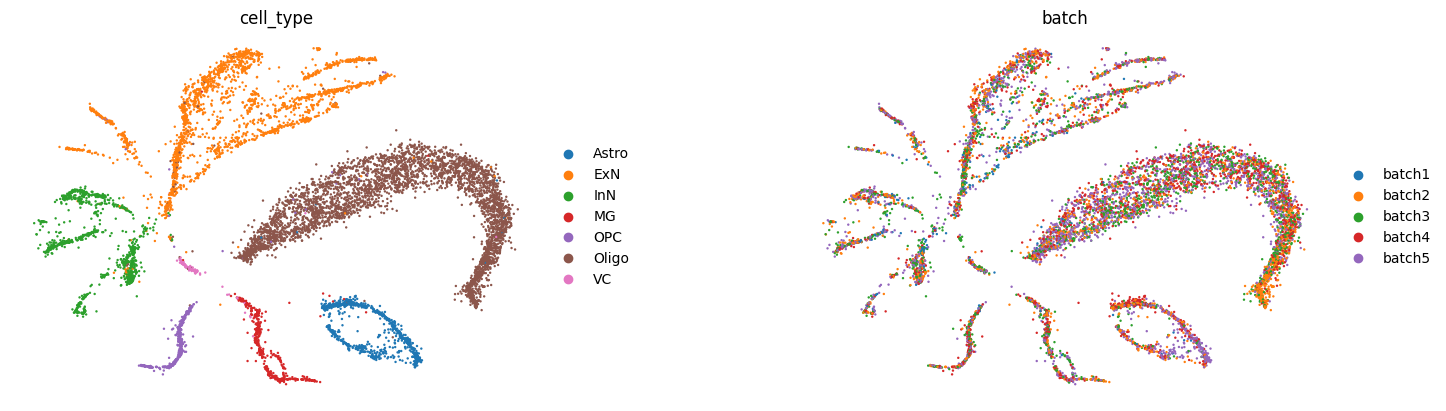

In [219]:
# sc.pl.umap(adata, color=['study', 'cell_type'], wspace=0.35)

sc.pl.embedding(
    test_ad,
    basis="X_mde",
    color=[CELL_TYPE_KEY, "batch"],
    frameon=False,
    wspace=0.35,
)

In [224]:
# train_ad.X = train_ad.raw.X # put raw counts to .X
train_ad

AnnData object with n_obs × n_vars = 40000 × 3000
    obs: 'seurat_clusters', 'cell_type', 'sample', 'doublet_score', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'percent.rb', 'batch', 'S.Score', 'G2M.Score', 'Phase', 'RNA_snn_res.0.3', 'ExN1', 'InN2', 'MG3', 'Astro4', 'Oligo5', 'OPC6', 'VC7', 'type', 'UMAP_1', 'UMAP_2', 'clean', 'test', 'train', 'tmp', 'size_factors', 'margin', 'entropy', 'maxprob', 'pred'
    var: 'feat'
    uns: 'pca', 'cell_type_colors', 'batch_colors', 'sample_colors', 'pred_colors'
    obsm: 'X_pca', 'X_mde', 'X_cvae', 'X_mde2'
    varm: 'PCs'

In [220]:
train_ad.obs['size_factors'] = train_ad.X.sum(1)

In [ ]:
train_ad = train_ad[subsamples,:] # no copy... just alias

## Check the results

In [221]:
test_data = test_dataloader.dataset[:] # No copies yet, nothing is copied until you access specific attributes (.X, .obsm etc.).

In [222]:
means = cvae.encoder(test_data.X, test_data.obs['sample'])[:, :10] # get mean values of the latent variables

ValueError: Found unknown categories ['UMARY-1323-ARC', 'UMARY-5179-ARC', 'UMARY-1845-ARC', 'SH-95-34-ARC', 'UMARY-1675-ARC', 'UMARY-1743-ARC', 'UMARY-1486-ARC', 'KEN-1092-ARC', 'UMARY-4782-ARC', 'SH-98-23-ARC', 'UMARY-1859-ARC', 'UMARY-1134-ARC', 'UMARY-1570-ARC', 'UMARY-1935-ARC', 'UMARY-5114-ARC', 'SH-92-14-ARC', 'UMARY-602-ARC', 'SH-04-05-ARC', 'UMARY-1827-ARC', 'UMARY-1133-ARC', 'UMARY-1496-ARC', 'UMARY-1259-ARC', 'UMARY-4842-ARC', 'UMARY-1831-ARC', 'UMARY-1475-ARC', 'UMARY-4728-ARC', 'UMARY-55-ARC', 'UMARY-4228-ARC', 'UMARY-4549-ARC', 'SH-03-15-ARC', 'UMARY-1347-ARC', 'UMARY-871-ARC', 'SH-04-08-ARC', 'UMARY-1797-ARC', 'UMARY-794-ARC', 'UMARY-1543-ARC', 'KEN-1245-ARC', 'UMARY-5117-ARC', 'UMARY-4638-ARC', 'UMARY-4906-ARC', 'UMARY-1648-ARC'] in column 0 during transform

In [ ]:
train_ad.obsm['X_cvae'] = means.data.cpu().numpy()

In [ ]:
# sc.pp.neighbors(train_ad, use_rep='X_cvae')
# sc.tl.umap(train_ad)

train_ad.obsm['X_mde2'] = scvi.model.utils.mde(train_ad.obsm['X_cvae'])


The results of the study integration using our VAE model.

/Users/ergonyc/miniforge3/envs/scverse11/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/ergonyc/miniforge3/envs/scverse11/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


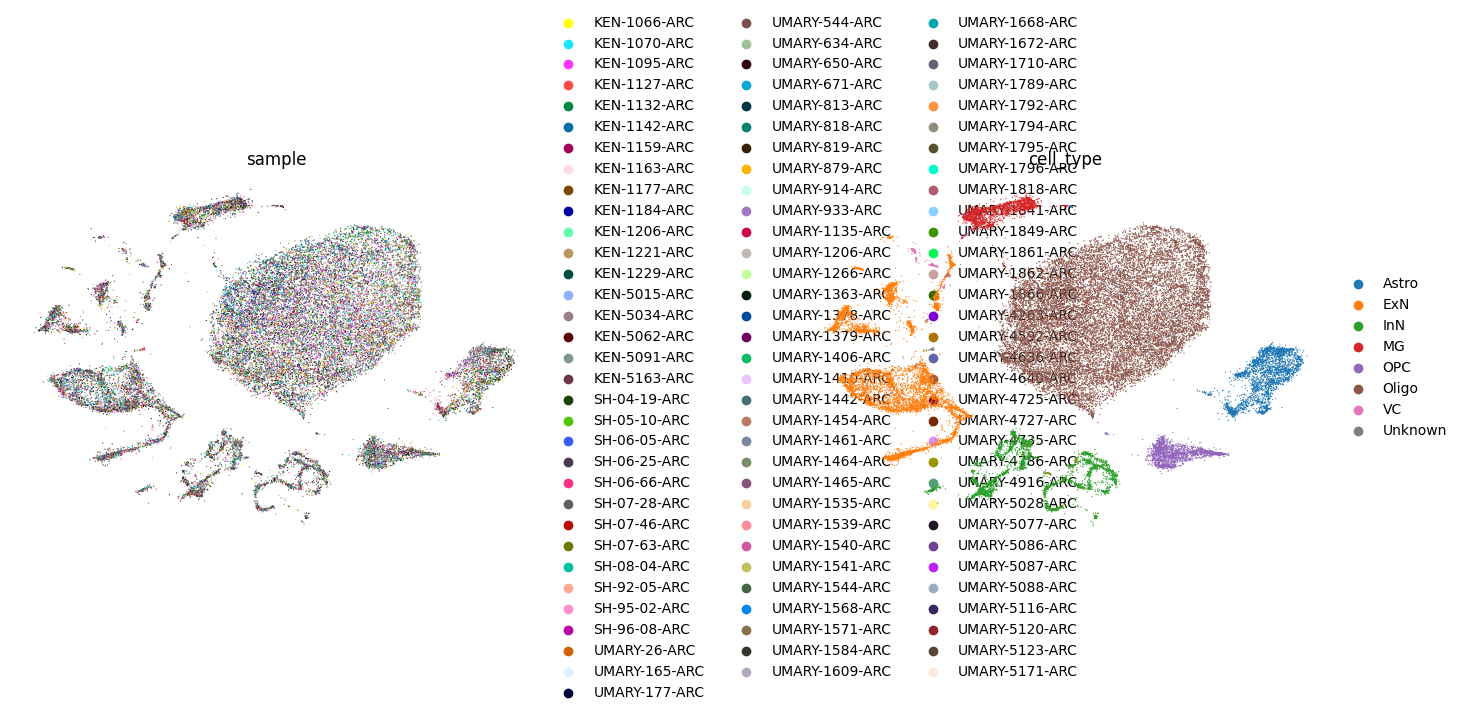

In [ ]:
# sc.pl.umap(adata, color=['study', 'cell_type'], wspace=0.35)
# # sc.pl.umap(adata, color=['study', 'cell_type'], wspace=0.35)

sc.pl.embedding(
    train_ad,
    basis="X_mde2",
    color=["sample", "cell_type"],
    frameon=False,
    wspace=0.35,
)


In [ ]:
preds = cvae.classifier(means).argmax(dim=-1)
labs = torch.tensor(encoder_celltype.transform(train_ad.obs['cell_type']))
accuracy = (preds==labs).sum().item()/train_ad.n_obs

In [ ]:
encoder_celltype.inverse_transform(preds)

array(['VC', 'Oligo', 'ExN', ..., 'MG', 'Oligo', 'Oligo'], dtype=object)

In [ ]:
train_ad.n_obs

tensor([[ 2.9354,  1.8235, -0.1486,  ...,  0.0210, -0.0204, -0.0467],
        [-0.2977,  0.7406,  0.3860,  ..., -0.0677,  0.0308, -0.0242],
        [-0.5130,  2.4466,  0.7728,  ...,  0.0406, -0.0267, -0.0259],
        ...,
        [ 1.0070,  1.5476,  1.7903,  ..., -0.0081,  0.0225, -0.0481],
        [-0.5239, -0.5073,  0.7861,  ..., -0.0812,  0.0437,  0.0175],
        [-1.6937, -0.1083,  1.2423,  ..., -0.0870,  0.0597,  0.0088]],
       grad_fn=<SliceBackward0>)

In [ ]:
import torch.nn.functional as F
from torch.distributions import Categorical

# Example logits from a neural network output
logits = cvae.classifier(means)

# Applying softmax to convert logits to probabilities
probabilities = F.softmax(logits, dim=1)

# Create a Categorical distribution
distribution = Categorical(probs=probabilities)

# Calculate entropy
entropy = distribution.entropy()

n_classes = probabilities.shape[1]

In [ ]:
probabilities[1,:].sum()

tensor(1., grad_fn=<SumBackward0>)

In [ ]:

logs = logits.detach().numpy()
probs = probabilities.detach().numpy()
ents = entropy.detach().numpy()
logents = entropy.log().detach().numpy()
maxprob = probs.max(axis=1)

# print("Logits: ", logs)
# print("Probabilities: ", probs)

maxprobs = probs.max(axis=1)


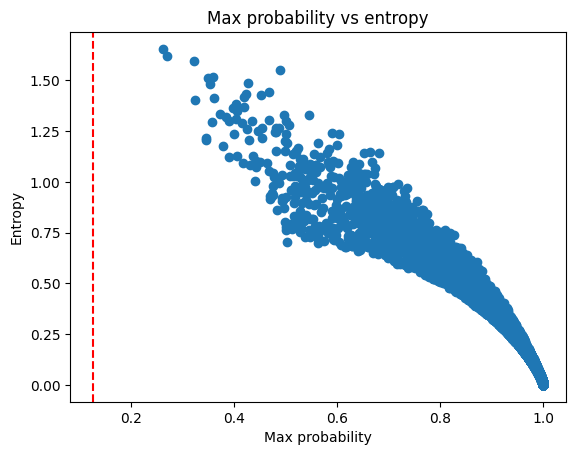

In [ ]:
# print("Entropy:", entropy)

# plt.scatter(means[:, 0], means[:, 1], c=entropy)

ax = plt.scatter(maxprobs,ents)
plt.xlabel("Max probability")
plt.ylabel("Entropy")
plt.title("Max probability vs entropy")
plt.axvline(x=1/n_cats, color='r', linestyle='--')


In [ ]:
cvae.classifier(means).argmax(dim=-1)

tensor([7, 5, 1,  ..., 3, 5, 5])

In [ ]:
torch.topk(probabilities, k=2, dim=1)
top_probs, _ = torch.topk(probabilities, k=2, dim=1)
top_probs[:,0] - top_probs[:,1]

tensor([0.9798, 0.9545, 0.7629,  ..., 0.9801, 0.9962, 0.9995],
       grad_fn=<SubBackward0>)

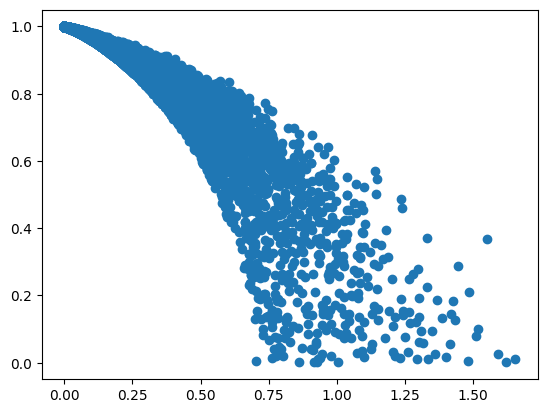

In [ ]:
def calculate_margin_of_probability(probabilities):

    # Get the top two probabilities
    top_probs, _ = torch.topk(probabilities, 2)

    # Calculate the margin
    margin = top_probs[:,0] - top_probs[:,1]
    return margin

# Get the top two probabilities
top_probs, _ = torch.topk(probabilities, k=2, dim=1)
# Calculate the margin
margin = top_probs[:,0] - top_probs[:,1]

# margs = calculate_margin_of_probability(probabilities)

plt.scatter(ents,margin.detach().numpy())



In [ ]:
train_ad.obs['margin'] = margin.detach().numpy()
train_ad.obs['entropy'] = entropy.detach().numpy()
train_ad.obs['maxprob'] = maxprob
train_ad.obs['pred'] = encoder_celltype.inverse_transform(preds)

/Users/ergonyc/miniforge3/envs/scverse11/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


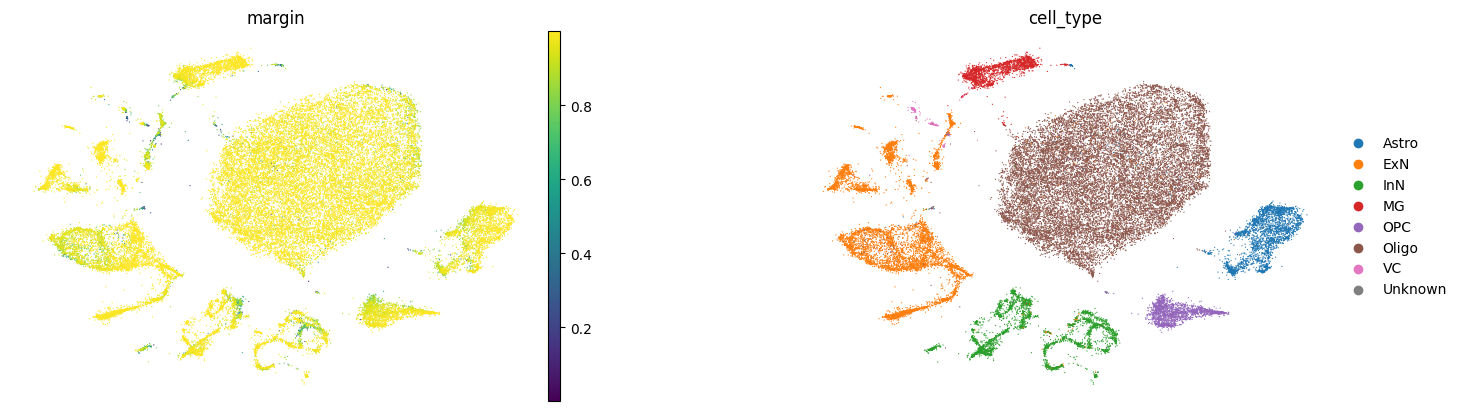

In [ ]:
sc.pl.embedding(
    train_ad,
    basis="X_mde2",
    color=["margin", CELL_TYPE_KEY],
    frameon=False,
    wspace=0.35,
)


/Users/ergonyc/miniforge3/envs/scverse11/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


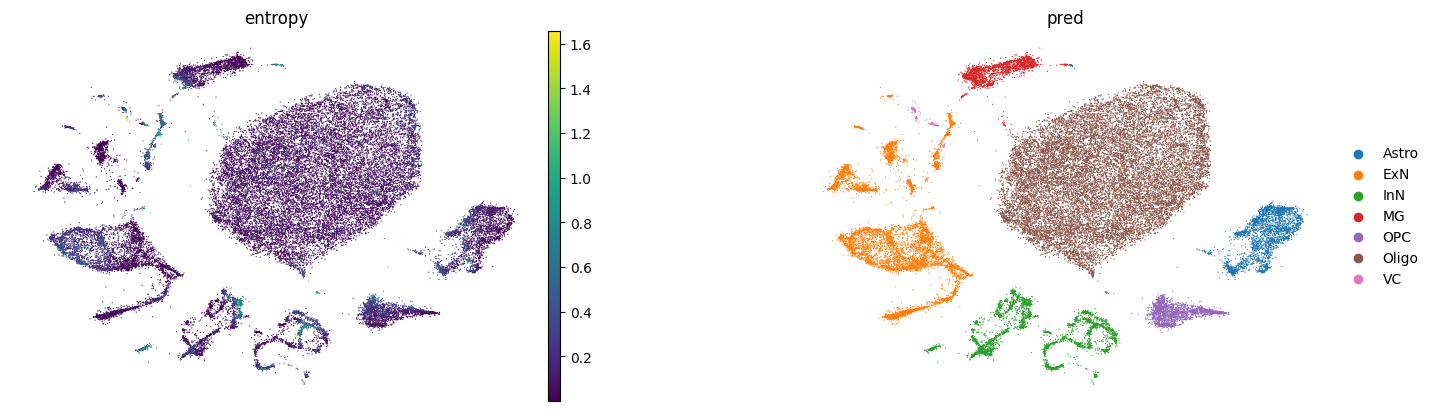

In [ ]:
sc.pl.embedding(
    train_ad,
    basis="X_mde2",
    color=["entropy", "pred"],
    frameon=False,
    wspace=0.35,
)


In [ ]:
train_ad.obs[train_ad.obs['cell_type']=='Unknown']

seurat_clusters cell_type         sample  \
cells                                                              
CACATAATCAAACCGT-1_138                1   Unknown  UMARY-933-ARC   

                        doublet_score  nCount_RNA  nFeature_RNA  percent.mt  \
cells                                                                         
CACATAATCAAACCGT-1_138       0.089965       11383          4936    0.131775   

                        percent.rb   batch   S.Score  ...    UMAP_2 clean  \
cells                                                 ...                   
CACATAATCAAACCGT-1_138    1.511025  batch5 -0.070626  ... -9.666387  True   

                         test  train                  tmp  size_factors  \
cells                                                                     
CACATAATCAAACCGT-1_138  False   True  nanOligodendrocytes        4374.0   

                          margin   entropy  maxprob  pred  
cells                                                      
CACATAATCAAACCGT-1_138  0.236207  1.085259  0.54742   ExN  

[1 rows x 32 columns]

In [ ]:
df = test_ad.obs.groupby(["C_scANVI", "ground_truth"]).size().unstack(fill_value=0)
norm_df = df / df.sum(axis=0)

plt.figure(figsize=(8, 8))
_ = plt.pcolor(norm_df)
_ = plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns, rotation=90)
_ = plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.title(f"scanvi accuracy: {np.mean(test_ad.obs.C_scANVI == test_ad.obs.ground_truth):.3f}")